In [418]:
import json
import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
from matplotlib import pyplot as plt
%matplotlib inline

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException

import time
import csv

In [6]:
url = requests.get('http://data.wnba.com/data/5s/v2015/json/mobile_teams/wnba/2018/players/10_player_info.json').json()

In [26]:
print("Number of players:", len(url['pls']['pl']))

Number of players: 276


In [44]:
### Convert JSON object to pandas dataframe

player_list = []
for i in np.arange(len(url['pls']['pl'])):
    #print(url['pls']['pl'][i]['pc'])
    co = url['pls']['pl'][i]['co']
    dob = url['pls']['pl'][i]['dob']
    dy = url['pls']['pl'][i]['dy']
    fa = url['pls']['pl'][i]['fa']
    fn = url['pls']['pl'][i]['fn']
    ht = url['pls']['pl'][i]['ht']
    la = url['pls']['pl'][i]['la']
    ln = url['pls']['pl'][i]['ln']
    num = url['pls']['pl'][i]['num']
    pc = url['pls']['pl'][i]['pc']
    pid = url['pls']['pl'][i]['pid']
    pos = url['pls']['pl'][i]['pos']
    s = url['pls']['pl'][i]['s']
    sn = url['pls']['pl'][i]['sn']
    ta = url['pls']['pl'][i]['ta']
    tc = url['pls']['pl'][i]['tc']
    tid = url['pls']['pl'][i]['tid']
    tn = url['pls']['pl'][i]['tn']
    ty = url['pls']['pl'][i]['ty']
    wt = url['pls']['pl'][i]['wt']
    y = url['pls']['pl'][i]['y']
    
    player_list.append([co, dob, dy, fa, fn, ht, la, ln, num, pc, pid, pos, s, sn, ta, tc, tid, tn, ty, wt, y])

df_players = pd.DataFrame(player_list, columns = ['co', 'dob', 'dy', 'fa', 'fn', 'ht', 'la', 'ln', 'num', 'pc', 'pid', 'pos', 's', 'sn',
                                    'ta', 'tc', 'tid', 'tn', 'ty', 'wt', 'y'])

In [47]:
df_players.head()

,co,dob,dy,fa,fn,ht,la,ln,num,pc,pid,pos,s,sn,ta,tc,tid,tn,ty,wt,y
0,,1992-11-06,0,N,Rebecca,6-2,Australia,Allen,9,rebecca_allen,204296,G,A,Australia,NYL,New York,1611661313,Liberty,From,162.0,3
1,,1995-03-20,2017,N,Lindsay,5-8,Notre Dame,Allen,12,lindsay_allen,1628263,G,I,Notre Dame,NYL,New York,1611661313,Liberty,College,144.0,1
2,,1993-06-11,2015,N,Brittany,5-9,California,Boyd,15,brittany_boyd,204327,G,A,California,NYL,New York,1611661313,Liberty,College,156.0,3
3,,1996-07-31,0,N,Tashia,6-1,Western Kentucky,Brown,,tashia_brown,1628883,F,I,Western Kentucky,NYL,New York,1611661313,Liberty,College,NaN,0
4,USA,1988-12-05,2010,N,Tina,6-4,Connecticut/USA,Charles,31,tina_charles,202250,C,A,Connecticut,NYL,New York,1611661313,Liberty,College,192.0,8


In [48]:
### Save pc (player id) to pull historical stats for each player
plr_id = list(map(lambda x: x.replace('_', '-'), df_players['pc']))

In [191]:
print("Number of players:", len(plr_id))

Number of players: 276


In [247]:
plr_id[194:200]

['marissa-coleman',
 'candice-dupree',
 'bashaara-graves',
 'jazmon-gwathmey',
 'jennifer-hamson',
 'briann-january']

In [255]:
start_time = time.time()
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
browser = webdriver.Chrome(chrome_options=chrome_options)
#df = pd.DataFrame()

player_count = 195
invalid_players = []


for plr in plr_id[195:]:
    try:
        
        browser.get('http://www.wnba.com/player/'+str(plr)+'/#/gamelogs')
        action = ActionChains(browser) # create ActionChains object
        #browser.find_elements_by_xpath('//select[@name="filter_year"]')
        contract = browser.find_element_by_xpath('//select[@name="filter_year"]')
        action.move_to_element(contract).perform()
        time.sleep(2)
        #contract = browser.find_element_by_xpath('//div[@class="profile__filter"]')
        try:
            contract.click()
        except:
            popup = browser.find_element_by_xpath('//a[@onclick="window.PulseInsightsObject.survey.closeButtonClickedEvent()"]')
            time.sleep(1)
            popup.click()
            time.sleep(2)
            action.move_to_element(contract).perform()
            time.sleep(2)
            contract.click()


        time.sleep(2)

        contract = browser.find_element_by_xpath('//option[@value="2017-18"]')
        try:
            contract.click()

        except:
            pass
        
        time.sleep(1)
        rows = browser.find_elements_by_xpath('//section[@id="gamelogs"]/section/wnba-stat-table/div/div[@class="stat-table__overflow"]/table/tbody/tr/td')
        dates = browser.find_elements_by_xpath('//section[@id="gamelogs"]/section/wnba-stat-table/div/div[@class="stat-table__overflow"]/table/tbody/tr/th')
        games = len(dates)
        print("number of games:", games)
        row_index = 1
        date_index = 0
        row_list1 = []
        row_list2 = []
        date_list = []
        
        for row in rows:
            row_list1.append(row.text)
            if row_index % 15 == 0:
                row_list2.append(row_list1)
                row_list1 = []
                date_index += 1
            row_index += 1

        for date in dates:
            date_list.append([plr, date.text])

        df_dates = pd.DataFrame(date_list, columns = ['player','date'])
        df_stats = pd.DataFrame(row_list2, columns = ['opp', 'result', 'min', 'fgm-a', '3pm-a', 'ftm-a', 'oreb', 'dreb', 
                                                      'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts'])
        df_player = pd.concat([df_dates,df_stats], axis = 1)
        df = pd.concat([df, df_player], axis = 0)
        print("Player", player_count, plr, "completed:", time.time() - start_time)
    
    except NoSuchElementException:
        invalid_players.append(plr)
        pass
    except StaleElementReferenceException:
        invalid_players.append(plr)
        pass
    player_count += 1
browser.close()

number of games: 33
Player 195 candice-dupree completed: 21.44775700569153
number of games: 10
Player 196 bashaara-graves completed: 62.052749156951904
number of games: 28
Player 197 jazmon-gwathmey completed: 88.3671190738678
number of games: 12
Player 198 jennifer-hamson completed: 129.64228796958923
number of games: 25
Player 199 briann-january completed: 154.77193808555603
number of games: 14
Player 200 shenise-johnson completed: 176.2806749343872
number of games: 34
Player 201 erlana-larkins completed: 207.21992993354797
number of games: 30
Player 203 erica-mccall completed: 251.09390997886658
number of games: 27
Player 204 tiffany-mitchell completed: 276.0948579311371
number of games: 17
Player 206 alexis-peterson completed: 313.680438041687
number of games: 29
Player 207 jeanette-pohlen-mavunga completed: 340.37869095802307
number of games: 34
Player 210 erica-wheeler completed: 401.1915099620819
number of games: 30
Player 211 sue-bird completed: 430.1484670639038
number of game

In [233]:
invalid_players

['loryn-goodwin']

In [253]:
pd.set_option('display.max_rows', 1000)
df[df['player'] == 'candice-dupree']

,player,date,opp,result,min,fgm-a,3pm-a,ftm-a,oreb,dreb,reb,ast,stl,blk,to,pf,pts


In [256]:
df.tail()

,player,date,opp,result,min,fgm-a,3pm-a,ftm-a,oreb,dreb,reb,ast,stl,blk,to,pf,pts
30,tamera-young,"MAY 26, 2017",CHI @ WAS,L,31,6 - 13,1 - 1,3 - 4,0,3,3,1,1,0,2,5,16
31,tamera-young,"MAY 24, 2017",CHI vs. WAS,L,32,5 - 12,1 - 3,3 - 4,1,4,5,3,1,1,3,3,14
32,tamera-young,"MAY 21, 2017",CHI @ ATL,W,38,5 - 13,1 - 2,1 - 3,0,3,3,2,2,0,4,3,12
33,tamera-young,"MAY 19, 2017",CHI vs. ATL,L,38,5 - 21,2 - 5,6 - 6,1,2,3,3,4,0,3,4,18
34,tamera-young,"MAY 14, 2017",CHI @ MIN,L,32,6 - 14,0 - 1,2 - 6,1,7,8,4,2,1,1,2,14


In [259]:
df.to_csv('wnba_2017_gamelogs.csv')

In [ ]:
df = pd.read_csv('wnba_2017_gamelogs.csv')

In [274]:
len(list(map(lambda x: x.find('@'), df['opp'])))

3479

In [263]:
print("number of total players scraped:",len(df['player'].unique()))

number of total players scraped: 113


In [328]:
#### Create a cleaner dataframe

#Make date into datetime format
df['date'] = pd.to_datetime(df['date'])

#Make opp into team / opponent / home or road game
home_away = []
for i in (list(map(lambda x: x.find('@'), df['opp']))):
    if i ==  -1:
        home_away.append('home')
    else:
        home_away.append('away')
df['home_away'] = home_away

team_list = []
opp_list = []
for i in df['opp']:
    team_list.append(i[:3])
    opp_list.append(i[-3:])
df['team'] = team_list
df['opponent'] = opp_list

#Separate fgm-a into fgm and fga 
df['fgm'] = list(map(lambda x: x[:x.find('-')-1], df['fgm-a']))
df['fga'] = list(map(lambda x: x[x.find('-')+2:], df['fgm-a']))

#Separate 3pm-a into 3pm and 3pma
df['3pm'] = list(map(lambda x: x[:x.find('-')-1], df['3pm-a']))
df['3pa'] = list(map(lambda x: x[x.find('-')+2:], df['3pm-a']))

#Separate ftm-a into ftm and ftm-a
df['ftm'] = list(map(lambda x: x[:x.find('-')-1], df['ftm-a']))
df['fta'] = list(map(lambda x: x[x.find('-')+2:], df['ftm-a']))

df = df.drop(['opp','fgm-a','3pm-a','ftm-a'], axis = 1)

In [333]:
df.shape

(3479, 22)

In [331]:
df.sort_values('date')

,player,date,result,min,oreb,dreb,reb,ast,stl,blk,to,pf,pts,home_away,team,opponent,fgm,fga,3pm,3pa,ftm,fta
31,bria-holmes,2017-05-13,W,31,0,4,4,1,1,0,1,4,15,away,ATL,CON,6,12,0,4,3,3
31,bria-holmes,2017-05-13,W,31,0,4,4,1,1,0,1,4,15,away,ATL,CON,6,12,0,4,3,3
25,tiffany-jackson-jones,2017-05-13,W,32,4,4,8,0,0,0,2,2,8,home,LAS,SEA,4,9,0,0,0,0
33,kiah-stokes,2017-05-13,W,18,2,2,4,2,0,1,0,3,2,home,NYL,SAN,1,3,0,0,0,0
33,elizabeth-williams,2017-05-13,W,30,1,8,9,1,0,1,1,2,8,away,ATL,CON,4,9,0,0,0,0
32,ramu-tokashiki,2017-05-13,L,30,1,3,4,1,1,1,1,3,14,away,SEA,LAS,6,10,0,1,2,2
33,chelsea-gray,2017-05-13,W,28,1,1,2,8,2,0,1,4,14,home,LAS,SEA,6,13,2,3,0,0
33,crystal-langhorne,2017-05-13,L,33,0,6,6,2,0,1,3,2,13,away,SEA,LAS,5,7,0,0,3,3
32,sami-whitcomb,2017-05-13,L,7,0,3,3,0,0,0,3,1,3,away,SEA,LAS,1,3,1,3,0,0
33,jonquel-jones,2017-05-13,L,27,7,13,20,0,2,2,2,3,8,home,CON,ATL,3,11,0,1,2,2


Number of teams: 12
Teams: ['NYL' 'LAS' 'SAN' 'PHO' 'IND' 'ATL' 'SEA' 'CHI' 'DAL' 'WAS' 'CON' 'MIN']


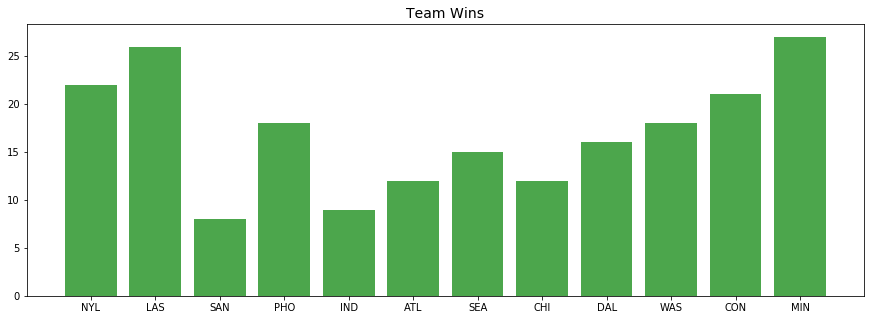

In [426]:
#some quick eda and create a team summary dataframe
print("Number of teams:", len(df['team'].unique()))
print("Teams:",df['team'].unique())


#players per team
tm_plr_count = []
for tm in df['team'].unique():
    df_tm = df[df['team'] == tm]
    #print(tm, "--",len(df_tm['player'].unique()))
    tm_plr_count.append([tm, len(df_tm['player'].unique())])
df_plr_count = pd.DataFrame(tm_plr_count, columns =['team', 'player_count'])

#team standings
tm_record = []
for tm in df['team'].unique():
    df_tm = df[df['team'] == tm]
    wins = len(df_tm[df_tm['result'] == 'W'].groupby(['result', 'date']).count())
    losses = len(df_tm[df_tm['result'] == 'L'].groupby(['result', 'date']).count())
    #print(tm, "---", wins, "-", losses)
    tm_record.append([tm, wins, losses])
df_tm_record = pd.DataFrame(tm_record, columns = ['team', 'wins','losses'])

df_tm = pd.merge(df_tm_record, df_plr_count, how='left', on='team')

plt.figure(figsize=(15,5))
plt.title('Team Wins', fontsize=14)
plt.bar(df_tm['team'], df_tm['wins'], color='green', alpha = .7);

#player standings


In [427]:
df_tm

,team,wins,losses,player_count
0,NYL,22,12,12
1,LAS,26,8,10
2,SAN,8,26,12
3,PHO,18,16,12
4,IND,9,26,12
5,ATL,12,22,13
6,SEA,15,19,11
7,CHI,12,22,13
8,DAL,16,18,11
9,WAS,18,16,6
